# SuperFish [ 7/8/2025 ]
implemented full space charge solves - CN

## Import Block

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
mpl.rcParams['axes.linewidth'] = 1.2
from numpy.linalg import norm
#from numba import njit
#from numba.experimental import jitclass
from scipy.interpolate import RegularGridInterpolator, interp1d
#import pycharge as pc
pycharge_flag=1
c = 3E8
f_res = 2.856e9
Amp_fac=0.12
phi_RF = 0 #np.pi
omega = 2*np.pi*f_res

#space charge solver
import spacecharger as sc

EPSILON_0 = 8.85E-12
COULOMB_K = 1 / (4 * np.pi * EPSILON_0)

## Constants

In [2]:
beam_charge = 1e-4 # was 1e-9 -CN                             # Beam Charge
q = 1.6e-19                                    # Proton charge
me = 9.1e-31                                   # Electron mass
Nt = 75                                        # Number of timesteps
L = 4.13*0.0254                                # Length scale in m (set this to overall beamtube length or similar)
dt = L/(50*c) #1.0/(10*omega_f)                # Timestep size -- set based on light transit time
t = np.linspace(0,Nt*dt,Nt,endpoint=False)
Np = 50                                      # Number of particles
p_charge = -beam_charge/Np                     # charge of each macroparticle (beam charge/Np)
p_mass = abs(p_charge/q*me)                    # Macroparticle mass (beam charge/q*me)
v0 = 2.9e8                                     # Initial beam velocity
sigma_x = 0.001                                # Beam radius std deviation
r_c = 0.0375                                   # Not used
sigma_u = 0.001                                # std deviation in initial momentum
Ibeam = -beam_charge*v0                        # Beam current
beam_pos_shift = np.array([0,0.038,0.038])     # Beam position shift (not used)

## Particle Generation

In [3]:
Npart = int(Np) # number of particles
spotsize = 5e-4  # spot size, like rad of bunch
bunchLength = 3.2e-5
velz = 1.46717e-03 #initial
parts = np.zeros([Npart,6])

parts[0] = np.array([0,0,0,0,-bunchLength/2,velz])
for i in range(1,Npart):
    parts[i,-2] = np.random.uniform(low=-bunchLength,high=0)
    parts[i,-1] = velz
    x = np.random.uniform(low=-spotsize/2,high=spotsize/2)
    y = np.random.uniform(low=-spotsize/2,high=spotsize/2)
    if (np.sqrt(x**2 + y**2) < spotsize/2):
        parts[i,0] = x
        parts[i,2] = y #r*np.sin(th)

np.savetxt('partcl.data', parts)

## Space Charge Parameters
Note that I set anything that may be changed later to -1.

In [4]:
# Define flags to turn on Space Charge (SC_FLAG) and CST fields (CST_FLAG)
SC_FLAG = 1.0
CST_FLAG = 0.0 # temp disabled because all we care about right now is space charge expansion

main_config = dict(
        INTEGRATOR = "Trapezoidal", #Can be "Trapezoidal" or "Gaussian"
        SHOW_GAUSSIAN_FIT = True,
        SHOW_MESH = False,
        SAVE_PLOTS = True,
        OUT_PATH = ".",
        SEED_RNG = True
    )

#notes, 7 mesh points and 64 quad points seem to work decently well for
# mu_v = 2.6E8, sig_v = 5E6, rad = 1E-4, integ = trap
mesh_config = dict(
    X_MESH_PTS = 5,
    Y_MESH_PTS = 5,   # set to -1 to set dy = dx
    Z_MESH_PTS = 49,  # set to -1 to set dz = dx
    QUAD_PTS = 48
)

gaussfits_config = dict(
    NUM_BINS = 1,
    NUM_GAUSSIANS = 1,
    WIDTH_GAUSSIANS = -1 # set to -1 to auto infer based on bunch length (works p well)
)

## Custom Interpolator


In [5]:
class BilinearInterpolator:
    # Create the interpolator with data for interpolation
    def __init__(self, points, data, force_regular_spacing, grid_tolerance=0.05):
        self.x_vals, self.y_vals = points
        self.data = np.array(data)

        # Run some basic checks for the input data
        self.__sanitizeCoordinates();

        # if the data is reasonable, then do the spacing checks
        self.dx = np.diff(self.x_vals).flat
        self.dy = np.diff(self.y_vals).flat

        if not self.__isRegularlySpaced(grid_tolerance) and force_regular_spacing:
            print(f"dx: {self.dx[0]},\t dy{self.dy[0]}")
            raise ValueError("Input x and y arrays are not evenly spaced!")

    def __call__(self, point):
        """Calls the bilinear interpolation routine when provided a x,y point."""
        x_vals, y_vals, data = self.x_vals, self.y_vals, self.data
        x, y = point


        # As we are regularly spaced, we can use the simple floor method to
        # get the index of the value closest to the interpolant
        lower_index_x = int((x - x_vals[0])/self.dx[0])
        lower_index_y = int((y - y_vals[0])/self.dy[0])

        print(x, y, lower_index_x, lower_index_y)
        print(self.dx, self.dy)

        if lower_index_x < 0:
            print("X LOOB")
            print(f"REQUESTED X: {x}, CLOSEST VALUE: {x_vals[0]}")

        if lower_index_x > data.shape[0]:
            print("X HOOB")
            print(f"REQUESTED X: {x}, CLOSEST VALUE: {x_vals[-1]}")

        if lower_index_y < 0:
            print("Y LOOB")
            print(f"REQUESTED Y: {y}, CLOSEST VALUE: {y_vals[0]}")

        if lower_index_y > data.shape[1]:
            print("Y HOOB")
            print(f"REQUESTED Y: {y}, CLOSEST VALUE: {y_vals[-1]}")

        # build the f(Q_xy) dudes
        q11 = data[lower_index_x][lower_index_y]
        q12 = data[lower_index_x][lower_index_y + 1]
        q21 = data[lower_index_x + 1][lower_index_y]
        q22 = data[lower_index_x + 1][lower_index_y + 1]

        # and the x1,x2,y1,y2 dudes
        x1 = x_vals[lower_index_x]
        x2 = x_vals[lower_index_x + 1]
        y1 = y_vals[lower_index_y]
        y2 = y_vals[lower_index_y + 1]


        # the expanded form of that matrix equation on top
        return (q11 * (x2 - x) * (y2 - y) +
                q12 * (x2 - x) * (y - y1) +
                q21 * (x - x1) * (y2 - y) +
                q22 * (x - x1) * (y - y1)) / ((x2 - x1) * (y2 - y1))

    def __sanitizeCoordinates(self):
        x_vals, y_vals, data = self.x_vals, self.y_vals, self.data
        """Does basic checks for the input data."""

        # Ensures that there are enough points in the data array to
        # actually do an interpolation (in this case, 2 for x and 2 for y)
        if len(x_vals) < 2 and len(y_vals) < 2:
            raise ValueError("Not enough points for an interpolation!")

        # Ensures that the x and y values for the input data have a value
        if len(x_vals) * len(y_vals) != data.size:
            raise ValueError("Not every x and y point has a value!")

        # Ensures that x and y array is monotonically increasing
        if not all(i<j for i, j in zip(x_vals, x_vals[1:])):
            raise ValueError("The x array is not monotonically increasing!")

        if not all(i<j for i, j in zip(y_vals, y_vals[1:])):
            raise ValueError("The y array is not monotonically increasing!")

    def __isRegularlySpaced(self, tolerance):
        """Checks if the spacing beween the x and y arrays is consistent between
        themselves and each other."""
        dx, dy = self.dx, self.dy

        # Check if the x and y values are evenly spaced
        if (np.allclose(dx, dx[0], rtol=tolerance) and np.allclose(dy, dy[0], rtol=tolerance)):
            # and that the x and y values are evenly spaced from each other
            return np.allclose(dx[0], dy[0], rtol=tolerance)
        else:
            return False

## Handy Field Conversions

In [6]:
def Exint(r):
    r = np.flip(r)
    rad = np.sqrt(r[0]**2 + r[1]**2)
    th = math.atan2(r[1],r[0])
    z = r[-1]

    return [ERint((z,rad))*np.cos(th)]

def Eyint(r):
    r = np.flip(r)
    rad = np.sqrt(r[0]**2 + r[1]**2)
    th = math.atan2(r[1],r[0])
    z = r[-1]

    return [ERint((z,rad))*np.sin(th)]

def Ezint(r):
    r = np.flip(r)
    rad = np.sqrt(r[0]**2 + r[1]**2)
    th = math.atan2(r[1],r[0])
    z = r[-1]

    return [EZint((z,rad))]

def Bxint(r):
    r = np.flip(r)
    rad = np.sqrt(r[0]**2 + r[1]**2)
    th = math.atan2(r[1],r[0])
    z = r[-1]

    return [-BTint((z,rad))*np.sin(th)]

def Byint(r):
    r = np.flip(r)
    rad = np.sqrt(r[0]**2 + r[1]**2)
    th = math.atan2(r[1],r[0])
    z = r[-1]

    return [BTint((z,rad))*np.cos(th)]

def B_phi(x, y, z):
    r = np.hypot(x, y)
    phi = np.arctan2(y, x)
    bx = BXint([x,y,z])
    by = BYint([x,y,z])
    return -bx * np.sin(phi) + by * np.cos(phi)

# Method and Code Breakdown

Let's assume axisymmetric fields, i.e $\partial_{\theta} E_{\theta} = 0$, and time harmonic variation, i.e $E(\vec{r},t) = \tilde{E}(\vec{r})\cos(\omega t + \phi_{\text{RF}})$, $B(\vec{r},t) = \tilde{B}(\vec{r})\cos(\omega t + \phi_{\text{RF}})$. Then, from Gauss' Law
$$ \nabla \cdot \tilde{E} = 0 \implies \partial_{z}\tilde{E}_{z} + r^{-1}\partial_{r}r \tilde{E}_{r} = 0.$$
Or,
$$ r\tilde{E}_{r} = -\frac{r^{2}}{2}\partial_{z}\tilde{E}_{z} \implies \tilde{E}_{r} = -\frac{r}{2}\partial_{z}\tilde{E}_{z} = -\frac{r}{2}\tilde{E}_{z}'.$$
From Ampere's Law in frequency domain (with no free currents),
$$ \nabla\times \tilde{B} = j\omega\mu_{0}\epsilon_{0} \tilde{E} \implies r^{-1}\partial_{r} r B_{\theta} = j\omega c^{-2}E_{z}.$$
Or,
$$ B_{\theta} = j\omega\frac{r}{2 c^{2}} E_{z}.$$
Since, $E_{z} = \tilde{E}_{z}\cos(\omega t + \phi_{\text{RF}})$,
$$ B_{\theta} = -\frac{r\omega}{2 c^{2}}\tilde{E}_{z}\sin(\omega t + \phi_{\text{RF}}).$$
Loading in $E_{z}$ from CST, computing $E_{r}$, $B_{\theta}$ and computing $B_{x},B_{y},E_{x},E_{y}$ through
$$ E_{z} = \tilde{E}_{z}\cos(\omega t + \phi_{RF})$$
$$ E_{r} = -\frac{r}{2}\tilde{E}_{z}'\cos(\omega t + \phi_{RF})$$
$$ B_{\theta} = -\frac{\omega r}{2c^{2}}\tilde{E}_{z}\sin(\omega t + \phi_{RF})$$

Note: This saves on memory since I only have to export $\tilde{E}_{z}$ from CST, but I could theoretically spit out $\textbf{all}$ of the fields and use it on a cavity without nice symmetries as well.

In [7]:
def inputSuperfishfields(fname):
    with open(fname) as fin:
        lines = fin.readlines()
        linesplit = [lines[i].split() for i in range(len(lines))]
        Zmin = float(linesplit[0][0])/100
        Zmax = float(linesplit[0][1])/100
        Nz = int(linesplit[0][2])
        freq = float(linesplit[1][0])*1e6
        Rmin = float(linesplit[2][0])/100
        Rmax = float(linesplit[2][1])/100
        Nr = int(linesplit[2][2])

    rr = np.linspace(Rmin,Rmax,Nr+1,endpoint=True)
    zz = np.linspace(Zmin,Zmax,Nz+1,endpoint=True)

    print(Zmin, Zmax, Nz, Rmin, Rmax, Nr)

    E = np.zeros([Nz+1,Nr+1,2])
    Emag = np.zeros([Nz+1,Nr+1])
    Bt = np.zeros([Nz+1,Nr+1])

    linesplitE = linesplit[4::2]
    linesplitB = linesplit[5::2]

    for ind in range(len(linesplitE)):
        i = ind % (Nz+1)
        j = int(ind / (Nz+1)) - 1
        E[i,j,0] = float(linesplitE[ind][0])*1e6
        E[i,j,1] = float(linesplitE[ind][1])*1e6
        Emag[i,j] = float(linesplitE[ind][2])*1e6
        Bt[i,j] = float(linesplitB[ind][0])*4e-7*np.pi

    ERint = RegularGridInterpolator((zz,rr),E[:,:,1])
    EZint = RegularGridInterpolator((zz,rr),E[:,:,0])
    BTint = RegularGridInterpolator((zz,rr),Bt[:,:])

    return ERint,EZint,BTint, rr, zz, Emag

In [8]:
def Efld(r,t):
    try:
        E = Amp_fac*np.array([Exint(r)[0],Eyint(r)[0],Ezint(r)[0]])*np.cos(2*np.pi*f_res*t+phi_RF)
    except:
        E = np.array([0,0,0])
    return E

def Bfld(r,t):
    try:
        B = -Amp_fac*np.array([Bxint(r)[0],Byint(r)[0],0])*np.sin(2*np.pi*f_res*t+phi_RF)
    except:
        B = np.array([0,0,0])
    return B

Next, I define the space charge field. Using Gauss' Laws, if the radius is higher than the nominal beam radius,
$$ E_{r} = \frac{I_{b}}{2\pi\epsilon_{0}v_{z}a^{2}}r.$$
If $r<a$, $\rho_{r} = \rho\frac{r^{2}}{a^{2}}$ and thus
$$ E_{r} = \frac{I_{b}}{2\pi\epsilon_{0}v_{z}a^{4}}r^{3}.$$
The function below is divided by $r$ to make the cos/sin $\theta$ computations more convenient later.

Next, we define a particle class to store quantities like charge/mass. It isn't necessary for the simple program I'm writing here, but makes generalizing to more complex beams later easier. The most important thing here is the Boris routine that implements the Boris particle push. Without going into too much detail (ref. Birdsall and Langdon for the minutia), Boris implements the lorentz force
$$ \partial_{t} \mathbf{p} = q\mathbf{E} + q\mathbf{v}\times\mathbf{B}$$
in three steps, (1) add half of the electric force, rotate the trajectory analytically in accordance with a constant $\mathbf{v}\times\mathbf{B}$ and then add the other half of the electric force.

Doing the momentum update in this fashion conserves energy under magnetic rotations (Interestingly Boris is not symplectic. See Ramachandran et al. 2023 arXiv:2303.08037 for details).

In [9]:
class Particle():
    def __init__(self,q,m,vel,pos):
        self.q = q
        self.m = m
        self.vel = vel
        self.pos = pos
        self.Efld = np.zeros(3)
        self.Efld_r = np.zeros(3)
        self.Bfld = np.zeros(3)
        self.Bfld_r = np.zeros(3)
        self.theta = 0
        self.r = 0
        self.tlost = 0
        self.tsteplost = 0
        self.isLost = False

    def set_fields(self,Efld,Bfld):
        self.Bfld = Bfld
        self.Efld = Efld

    def Boris(self,dt):
        Uprime = np.zeros(3)
        gmma = 1.0/np.sqrt(1-norm(self.vel)**2/c**2)
        const1 = dt*self.q/(2*self.m)
        Upast = gmma*self.vel
        Uminus = Upast + const1*self.Efld
        gmma_new = np.sqrt(1 + norm(Uminus)**2/c**2)
        t = self.Bfld*const1/gmma_new
        Uprime = Uminus + np.cross(Uminus,t)
        Uplus = Uminus + np.cross(Uprime,2*t/(1+norm(t)**2))
        Unext = Uplus + const1*self.Efld
        self.vel = Unext/np.sqrt(1+norm(Unext)**2/c**2)
        self.pos = self.pos + dt*self.vel
        return self.pos,self.vel

Next, we initialize particle positions/velocities as well as time history arrays (maybe write to file when this code is made to run larger things)

Finally, we can put it all together. At each step, I compute an average radius/position of the beam and use it to evaluate space charge. Both fields are passed to Boris which pushes over the next $dt$ step.

In [10]:
def AmILost(normEfld,normBfld,normVel,posY):
    if (normEfld+normVel*normBfld < 1e-10):
        return True
    #if (abs(posY) > 7.575e-3):
    #    return True
    return False

In [11]:
def track_particles(CST_FLAG, SC_FLAG, zmax, simulation=None):
    rmean_hist = np.zeros(Nt)
    Nlost = 0
    isAlive = np.array([True for i in range(len(parts))])
    endFlag = False
    endind = -1
    bunchLength = 0
    for i in range(1, Nt):
        if(i%10 == 0):
            print ("Timestep ",i,"/",Nt)
        ii = np.where(isAlive == True)
        if len(ii[0]) == 0:
            rmean = [0,0]
            vmean = [0,0]
        else:
            rmean = np.mean(pos[ii[0],i-1],axis=0)
            vmean = np.mean(vel[ii[0],i-1],axis=0)
        rmean_hist[i-1] = 0
        #print(np.shape(pos))
        bunchLength = np.max(pos[ii[0],i-1,-1]) - np.min(pos[ii[0],i-1,-1])

        r = np.sqrt((pos[:,i-1,0])**2 + (pos[:,i-1,1])**2)
        #v_mean = np.mean(vel[:,i-1,0])
        #print(np.shape(r))

        # obtain the space charge fields (per particle)
        E_sc_all, B_sc_all = sc.routine(
                    parts=parts,
                    main_config=main_config,
                    mesh_config=mesh_config,
                    gaussfits_config=gaussfits_config
                )

        for j in range(len(parts)):
            if parts[j].isLost == True:
                pos[j,i] = pos[j,i-1]
                vel[j,i] = vel[j,i-1]
                continue

            if Np > 1 and SC_FLAG == 1:
                beta = vel[j,i-1,-1] / c
                # Er = Er_space_charge(r[j],np.max(r[ii]),Ibeam,bunchLength,beta) #E_sc
                # Bphi = Bphi_space_charge(r[j],np.max(r[ii]),beamCharge,bunchLength,beta) #B_Sc
                # E_sc = Er*np.array([pos[j,i-1][0],pos[j,i-1][1],0])
                # B_sc = 0.0 #Bphi*np.array([-pos[j,i-1][1],pos[j,i-1][0],0])
                # what is being shown here are three-vectors. I have these!!

                # replace these with my routine entirely.


                E_sc = E_sc_all[j]
                B_sc = B_sc_all[j]

                if j==1:
                    print("pos:", pos[j,i-1])
                    print("FIELD:", E_sc)
            else:
                E_sc = 0.0
                B_sc = 0.0

            if (pos[j,i-1,-1] <= 0):
                SC_FLAG = 0
            else:
                SC_FLAG = 1

            #print(CST_FLAG*Efld(np.flip(pos[j,i-1]),t[i-1]))
            parts[j].set_fields(CST_FLAG*Efld(np.flip(pos[j,i-1]),t[i-1])+(len(parts)-Nlost)/len(parts)*SC_FLAG*E_sc\
                                ,(CST_FLAG*Bfld(np.flip(pos[j,i-1]),t[i-1])+(len(parts)-Nlost)/len(parts)*SC_FLAG*B_sc))
                #print(parts[j].Efld)

            pos[j,i], vel[j,i] = parts[j].Boris(dt)
            if pos[j,i,-1] > zmax:
                endFlag = True
            if (CST_FLAG == 1 and i > 1):
                parts[j].isLost = AmILost(np.linalg.norm(Efld(np.flip(pos[j,i-1]),t[i-1])),np.linalg.norm(Bfld(np.flip(pos[j,i-1]),t[i-1])),\
                              np.linalg.norm(vel[j,i-1]),pos[j,i-1,-1])
                if(parts[j].isLost and parts[j].tsteplost == 0):
                    isAlive[j] = False
                    parts[j].tsteplost = i-1
                    parts[j].tlost = parts[j].tsteplost*dt
                    Nlost += 1
                    continue
        #rmean_hist[i-1] /= len(parts)
        rmean_hist[i-1] = np.max(r)
        if endFlag == True:
            endind = i
            break
    return rmean_hist, Nlost, isAlive, endind

# Simulations

In [12]:
ERint, EZint, BTint, rr, zz, Emag = inputSuperfishfields("1T1.T7")


R = rr[4]
Z = zz[4]
th = np.pi/6

r = np.array([R*np.cos(th), R*np.sin(th), Z])
print(Efld(r,1e-9))

0.0 0.29270745000000004 300 0.0 0.05 50
[1.98638778e+02 1.01793844e+02 1.56747123e+05]


In [13]:
np.max(zz)

np.float64(0.29270745000000004)

In [14]:
np.max(rr)

np.float64(0.05)

In [15]:
#phi_RF = np.pi/2
dt = 1e-11 #1.0/(71*f_res)
Nt = 150 #)
t = np.linspace(0,Nt*dt,Nt,endpoint=False)
f_res = 1.3e9
Amp_fac = 28.836*(10/61.33) # 6.3 MV/m
phi_RF = np.pi/2+45/180*np.pi
print(Efld(np.flip(r),0))
print(Bfld(np.flip(r),0))

def AmILost(normEfld,normBfld,normVel,posZ):
    if ((normEfld < 1e-10) and (posZ > 0)):
        return True
    return False


partsIMP = np.loadtxt("partcl.data")
# partsIMP = partsIMP[::10]
#print("Grad: ", Amp_fac)
#plt.hist(partsIMP[:,-2],bins=32)

[-9.10653686e+03 -5.25766151e+03 -7.03131138e+06]
[ 0.00080044 -0.0013864  -0.        ]


NP 50
BIGDAVE (3v of a rand part): [       0.        0. 40000000.]
labvel [       0.        0. 40000000.], labpos [ 0.0e+00  0.0e+00 -1.6e-05]
Bunch Max radius: 0.0002482304419983113
FIT PARAMS 
 BINS: 1 
 NGAUS: 1          
 WIDTH: 6.01764675400442e-05 
 SCALE: -2e-10
6.01764675400442e-05


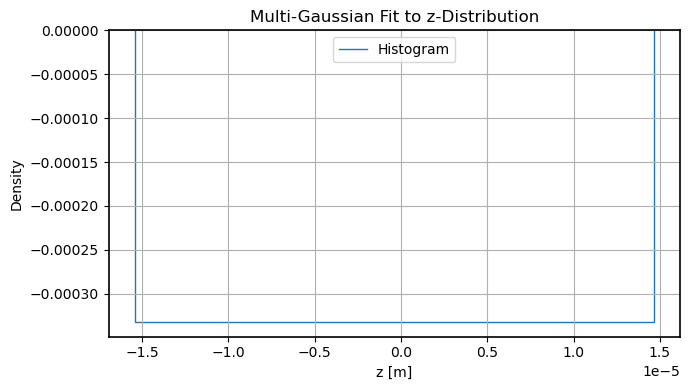

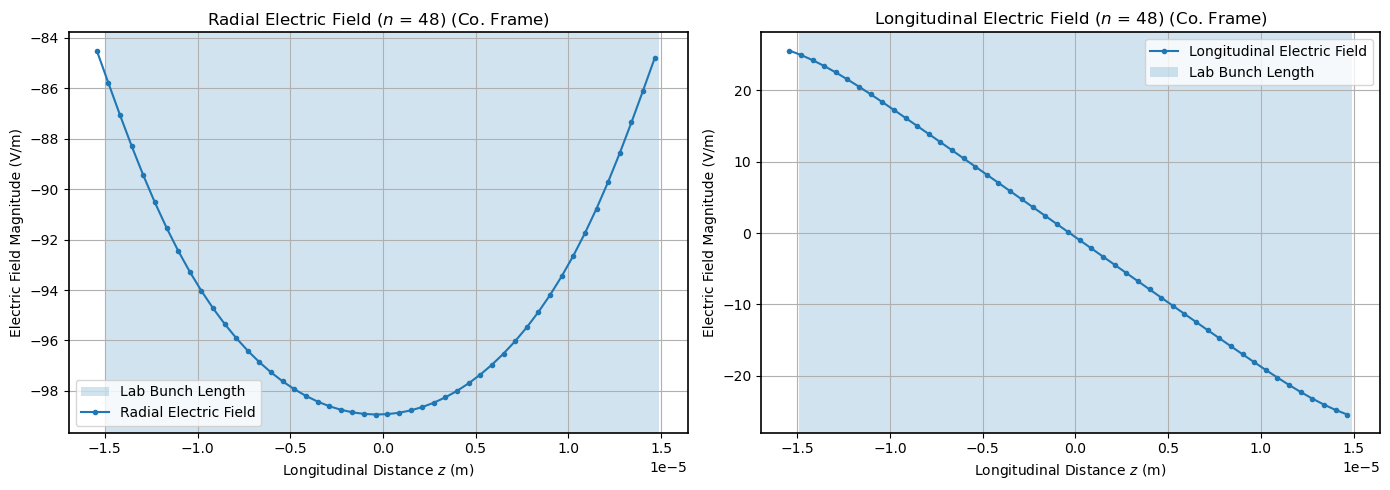

[ CYCLE DONE ] 
 

BIGDAVE (3v of a rand part): [       0.        0. 40000000.]
labvel [       0.        0. 40000000.], labpos [0.       0.       0.000384]
Bunch Max radius: 0.0002482304419983113
FIT PARAMS 
 BINS: 1 
 NGAUS: 1          
 WIDTH: 6.0176467540044184e-05 
 SCALE: -2e-10
6.0176467540044184e-05


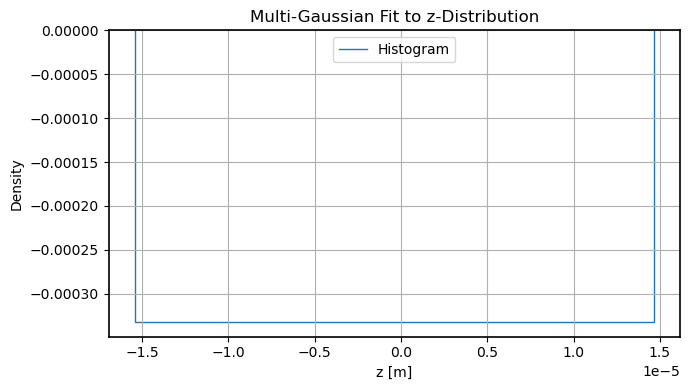

KeyboardInterrupt: 

In [16]:
#charges = np.linspace(0.1,10,21)
#charge_AG = np.zeros(21)

#start_overall = time.time()
#for k in range(len(charges)):
#print("Analysing ", charges[k], "nC")
vel = np.zeros([len(partsIMP),Nt,3])
pos = np.zeros([len(partsIMP),Nt,3])
parts = []
Np = len(partsIMP)
print("NP", Np)

q = 1.6e-19
me = 9.1e-31
chargenC = 10

beamCharge = -1e-9*chargenC
Ibeam = 1.3*chargenC

p_charge = beamCharge/Np
p_mass = abs(p_charge/q)*me

# vel[0,0,2] = 4e7

for i in range(0, len(partsIMP)): # set first part to zero
    vel[i,0,0] = partsIMP[i,1]
    vel[i,0,1] = partsIMP[i,3]
    vel[i,0,2] = 4e7 #partsIMP[i,5]
    pos[i,0,0] = partsIMP[i,0]
    pos[i,0,1] = partsIMP[i,2]
    pos[i,0,2] = partsIMP[i,4]
    parts.append(Particle(p_charge,p_mass,vel[i,0],pos[i,0]))

# mass is taken care of in the declaration.

start = time.time()
rmean_hist, Nlost, isAlive, endind = track_particles(CST_FLAG, SC_FLAG, np.max(zz))
end = time.time()
charge_AG = (len(parts)-Nlost)/len(parts)*chargenC
#print("Laser Charge: ",charges[k], "nC; After Gun: ", charge_AG[k], "nC; Exec: ", end-start, "s")
#end_overall = time.time()
print("Exec Time Overall: ", end-start, "s")

In [ ]:
print(endind)

113


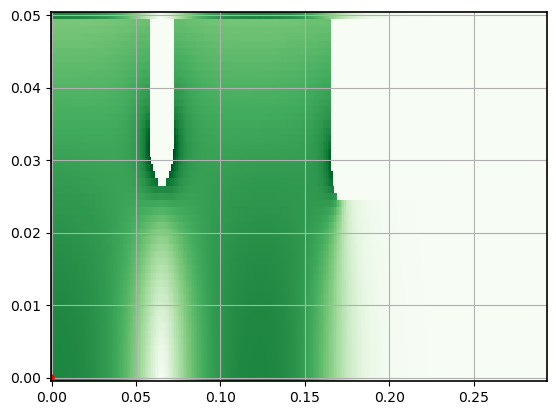

In [ ]:
Z,R = np.meshgrid(zz,rr)
plt.pcolormesh(Z,R,np.transpose(Emag),cmap="Greens")

# ind = endind-4
# print(n)
ind_1 = 0
ind_2 = 0

                # z             #r
plt.plot(pos[:,ind_1,-1],np.sqrt(pos[:,ind_1,0]**2 + pos[:,ind_1,1]**2),'r.',markersize=3,alpha=1)
plt.plot(pos[:,ind_2,-1],np.sqrt(pos[:,ind_2,0]**2 + pos[:,ind_2,1]**2),'r.',markersize=3,alpha=1)
plt.grid()

In [ ]:
print(vel[:,10,-1])

[2.60000001e+08 2.60000011e+08 2.60000062e+08 2.59999961e+08
 2.59999967e+08]


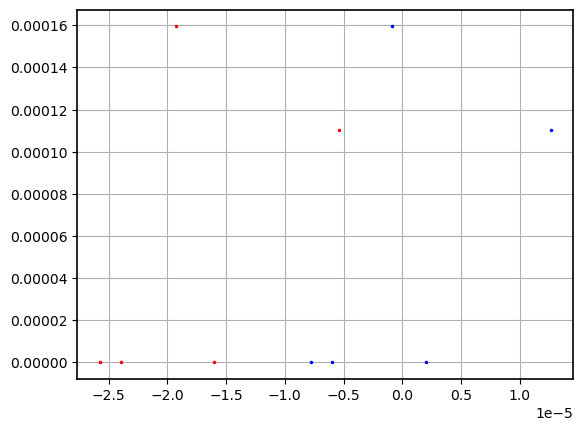

In [ ]:
plt.plot(pos[:,ind_1,-1],np.sqrt(pos[:,ind_1,0]**2 + pos[:,ind_1,1]**2),'r.',markersize=3,alpha=1)
plt.plot(pos[:,49,-1] - np.mean(pos[:,49,-1]),np.sqrt(pos[:,49,0]**2 + pos[:,49,1]**2),'b.',markersize=3,alpha=1)
plt.grid()
#plt.plot(pos[:,0,-1]-np.mean(pos[:,0,-1]),np.sqrt(pos[:,0,0]**2 + pos[:,0,1]**2),'b.',markersize=3,alpha=1)

# Nifty Animation Thing

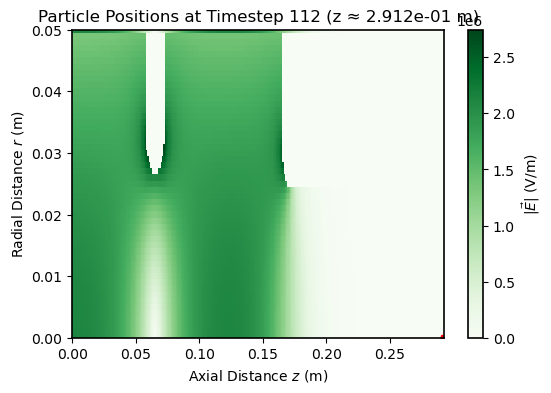

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Assuming you have:
# zz: 1D array of z positions
# rr: 1D array of r positions
# Emag: 2D array of field magnitudes (shape len(rr), len(zz))
# pos: particle positions, shape (n_particles, n_steps, 3)
# end_ind: final index to animate to

Z, R = np.meshgrid(zz, rr)

fig, ax = plt.subplots(figsize=(6, 4))

# Create the pcolormesh background
c = ax.pcolormesh(Z, R, Emag.T, cmap="Greens", shading='auto')
cb = fig.colorbar(c, ax=ax, label=r"$|\vec{E}|$ (V/m)")

# Initialize scatter plot for particles
scatter, = ax.plot([], [], 'r.', markersize=3, alpha=1)

ax.set_xlabel("Axial Distance $z$ (m)")
ax.set_ylabel("Radial Distance $r$ (m)")
title = ax.set_title("")

# Set plot limits to match your data
ax.set_xlim(zz[0], zz[-1])
ax.set_ylim(0, np.max(rr))

# Init function
def init():
    scatter.set_data([], [])
    title.set_text("")
    return scatter, title

# Update function for animation
def update(i):
    # Extract positions for frame i
    z_positions = pos[:, i, -1]
    r_positions = np.sqrt(pos[:, i, 0]**2 + pos[:, i, 1]**2)
    
    scatter.set_data(z_positions, r_positions)
    title.set_text(f"Particle Positions at Timestep {i} (z ≈ {z_positions.mean():.3e} m)")
    return scatter, title

# Create animation
ani = animation.FuncAnimation(
    fig, update, frames=endind, init_func=init,
    interval=100, blit=True
)

HTML(ani.to_jshtml())
